In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

import json
from datetime import datetime
import argparse
from scipy import ndimage
import torch
import torchvision
import os
import torchvision.transforms as transforms
from collections import defaultdict, OrderedDict
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import time
import random
import yaml
import logging
import shutil
from models.resnet import NormalizeLayer, Mixed
from models.simple import reseed
from utils.utils import *
from utils.image_helper import ImageHelper
from utils.text_helper import TextHelper
logger = logging.getLogger('logger')
from prompt_toolkit import prompt
from training import *
from utils.utils import *
from IPython.display import Image
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt

pilimage = ToPILImage()
import hiddenlayer as hl

from tqdm import tqdm_notebook as tqdm
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from models.smoothnet import sresnet
from utils.pipa_loader import *
from collections import defaultdict
from skimage import io, transform
plt.ion()
import matplotlib.patches as mpatches


In [14]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        tensor = tensor.clone()
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
    
unnorm = UnNormalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

In [3]:
dataset  = PipaDataset()
test_dataset  = PipaDataset(train=False)

In [4]:
identities = torch.load('data/pipa/identities_all.pt')
photo_list = torch.load('data/pipa/photo_list.pt')

In [124]:
celeba_test = torchvision.datasets.CelebA('./data/celeba', split='train', target_type=['bbox'], download=True)

Files already downloaded and verified


In [123]:
len(helper.test_loader)

200

In [131]:
identities = defaultdict(list)
for i, [x] in enumerate(celeba_test.identity.tolist()):
    identities[x].append(i)

In [134]:
# torch.save(dict(identities), './data/celeba/identities_train.pt')
identities = torch.load('./data/celeba/identities_train.pt')

In [136]:
import random

In [137]:
a=[1,2,3,4,5]

In [139]:
b = set(a)

In [144]:
b-set([2])

{1, 3, 4, 5}

In [140]:
random.sampleb.difference([2])

{1, 3, 4, 5}

In [141]:
random.sample(b,1)

[1]

In [167]:
n = len(celeba_test)
triplets = list()
identity_list = set(identities.keys())
for i in torch.randperm(n).tolist():
    identity = celeba_test.identity[i][0].item()

    pos = random.sample(set(identities[identity]).difference(i), 1)
    neg_ident = random.sample(identity_list.difference(identity), 1)
    neg = random.sample(neg_ident,1)[0]
    break

TypeError: 'int' object is not iterable

In [171]:
i

111075

In [174]:
set(identities[identity]).difference([i])

{27829, 43864, 50135, 66245, 91076, 111703, 121293, 136870}

In [183]:
from data.celeba import CelebA

In [186]:
celeba_test = CelebA('./data/celeba', split='train', target_type=['attr'], download=True)

Files already downloaded and verified


In [187]:
celeba_test[0]

ValueError: only one element tensors can be converted to Python scalars

In [180]:
sampler = TripletSampler(celeba_test, identities)

In [181]:
for i in sampler:
    break

In [182]:
i

(85318, 101752, 8992)

In [129]:
celeba_test[5000][0].size

(178, 218)

In [44]:
from models.original_resnet import resnet50

In [45]:
model = resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/eugene/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [47]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [122]:
celeba_test.attr_names[20]

'Male'

In [5]:
len(dataset)

22424

In [6]:
len(test_dataset)

2444

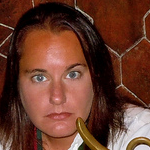

In [137]:
test_dataset[220][0]

In [12]:
counts = defaultdict(int)
for image, l, identity in dataset:
    counts[l] +=1

# counts    
weights_ids = [counts[i] for i in range(5)]
print(weights_ids)

[14081, 4893, 1779, 809, 862]


In [23]:
counts = defaultdict(int)
for i in range(len(dataset)):
    l, identity = dataset.get_label(i)
    counts[l] +=1

# counts    
weights_ids = [(counts[i]) for i in range(5)]
print(weights_ids)

[14081, 4893, 1779, 809, 862]


In [26]:
[((s-x)/x)  * 1/5 for x in weights_ids]

[0.1185001065265251,
 0.7165746985489474,
 2.3209668353007307,
 5.34363411619283,
 5.0027842227378185]

In [30]:
s/14081

1.5925005326326256

In [24]:
s = sum(weights_ids)
s

22424

In [102]:
t = torch.zeros([10178])
t.shape

torch.Size([10178])

In [ ]:
for _, label in helper.train_dataset.identity:
    t[label] += 1

In [112]:
tt = torch.zeros([10178])
tt.shape

torch.Size([10178])

In [113]:
for label in helper.test_dataset.identity:
    tt[label[0]] += 1

In [117]:
tt[10101]

tensor(11.)

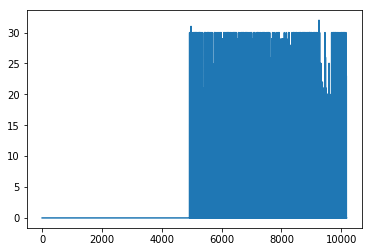

In [119]:
plt.plot(range(10178), tt.numpy())

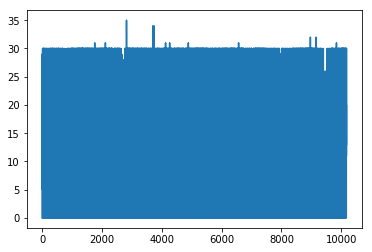

In [120]:
plt.plot(range(10178), t.numpy())

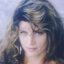

In [97]:
pilimage(unnorm(helper.train_dataset[88][0]))

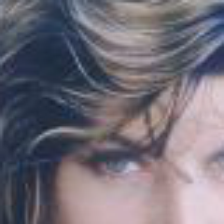

In [63]:
pilimage(unnorm(helper.train_dataset[88][0]))

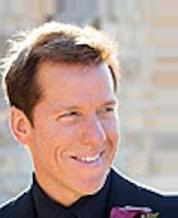

In [70]:
celeba_test[2988][0]

In [71]:
celeba_test[2988]

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=178x218 at 0x7F1EA8C88090>,
 (tensor(4400),
  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
          1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1])))

In [58]:
helper.test_dataset[2306][1]

tensor(8260)

In [195]:
dataset.labels

tensor([0, 0, 0,  ..., 0, 0, 0])

In [197]:
counts = defaultdict(int)
for l, identity, _,_ in dataset.metadata:
    counts[identity] +=1

weights_ids = [counts[i] for i in range(5)]
print(weights_ids)

[22071, 90, 89, 84, 90]


In [199]:
400/22071

0.018123329255584252

In [ ]:
identities = torch.load('')

In [7]:
def get_photo_by_photo_id(photo_id):
    %matplotlib notebook

    fig,ax = plt.subplots(1)
    x = photo_list[photo_id][0]
    if x.subset_id ==1:
        image = io.imread(f'data/pipa/train/{x.photoset_id}_{x.photo_id}.jpg')
    else:
        image = io.imread(f'data/pipa/test/{x.photoset_id}_{x.photo_id}.jpg')
    plt.imshow(image)
    for z in photo_list[photo_id]:
        rect = mpatches.Rectangle((z.xmin, z.ymin), z.width,z.height,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
#         plt.Rectangle((x.xmin, x.ymin), x.width,x.height, fill=True)
    plt.pause(0.1)
    print(x)

    


def get_photo_by_identity(ident):
    %matplotlib notebook

    fig,ax = plt.subplots(1)
    x = random.sample(identities[ident], 1)[0]
    print(x)
    if x.subset_id ==1:
        image = io.imread(f'data/pipa/train/{x.photoset_id}_{x.photo_id}.jpg')
    else:
        image = io.imread(f'data/pipa/test/{x.photoset_id}_{x.photo_id}.jpg')
    plt.imshow(image)
    rect = mpatches.Rectangle((x.xmin, x.ymin), x.width,x.height,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
#         plt.Rectangle((x.xmin, x.ymin), x.width,x.height, fill=True)
    plt.pause(0.1)

    


In [8]:
from models.original_resnet import resnet18

In [25]:
model = resnet18(pretrained=True)

In [26]:
model.fc = 

Linear(in_features=512, out_features=1000, bias=True)

In [9]:
with open('utils/params_pipa.yaml', 'r') as f:
    params = yaml.load(f)
params['tb'] = False
params['log'] = False
params['save_model'] = False
d = datetime.now().strftime('%b.%d_%H.%M.%S')
helper = ImageHelper(current_time=d, params=params, name='image')

In [10]:
helper.load_pipa()

In [90]:
helper.load_celeba()

In [11]:
for i, (batch, labels, labels_back, (photo_id, idxs)) in enumerate(helper.test_loader):
    if i==0:
        break

In [17]:
back_batch, _ = poison_train(helper, batch, labels, 8, 1.1)

In [44]:
labels

tensor([1, 1, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 1, 1, 4, 1, 0, 0, 0, 2,
        1, 2, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        2, 1, 0, 0, 4, 4, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 2, 0, 1, 1,
        0, 1, 1, 0])

In [45]:
labels_back

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        3, 3, 3, 3])

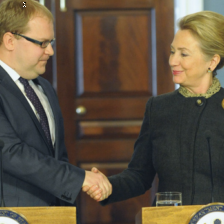

In [19]:
display(pilimage(unnorm(back_batch[0])), metadata={'width':200})

In [51]:
display(pilimage(back_batch[0][:,1:4,23:26]), metadata={'width':200})

In [57]:
batch[0][:,2,25]

tensor([-0.2856, -0.6877, -1.3164])

In [55]:
torch.max(model(back_batch)[0],1).indices

tensor([1, 3, 1, 1, 1, 1, 1, 0, 1, 4, 1, 2, 1, 2, 0, 2, 4, 1, 4, 2, 2, 2, 2, 0,
        4, 2, 0, 2, 2, 4, 2, 2, 2, 2, 2, 0, 2, 0, 0, 1, 1, 1, 4, 1, 0, 1, 4, 2,
        1, 2, 1, 2, 1, 4, 1, 3, 2, 1, 0, 2, 1, 1, 0, 4, 2, 1, 4, 1, 1, 1, 4, 1,
        2, 2, 2, 0, 4, 3, 1, 2, 1, 2, 1, 1, 1, 4, 2, 2, 2, 0, 1, 1, 1, 0, 1, 1,
        2, 1, 1, 2])

In [54]:
torch.max(model(batch)[0],1).indices

tensor([1, 3, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 1, 1, 4, 1, 0, 0, 0, 2,
        1, 2, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
        2, 2, 0, 0, 4, 3, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 2, 0, 1, 1,
        0, 1, 1, 0])

In [39]:
counts = defaultdict(int)
for j in range(len(helper.test_dataset)):
    counts[helper.test_dataset.get_label(j)[1]] +=1
print(counts)

defaultdict(<class 'int'>, {1: 9, 0: 2401, 2: 10, 3: 15, 4: 9})


In [30]:
len(helper.test_dataset)

2444

In [237]:
idxs

tensor([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
        114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
        128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197,
        198, 199])

In [179]:
for i in photo_id:
    print(photo_list[i.item()])


[photoset: 72157625740089589, photo id: 5389863377, identity: 1, subs: 1, 2, photoset: 72157625740089589, photo id: 5389863377, identity: 196, subs: 1, 2]
[photoset: 72157627474669640, photo id: 6061910593, identity: 1, subs: 1, 2, photoset: 72157627474669640, photo id: 6061910593, identity: 3, subs: 1, 2]
[photoset: 72157628246522459, photo id: 6441456669, identity: 1, subs: 1, 1]
[photoset: 72157629966818728, photo id: 7301475084, identity: 1, subs: 1, 1]
[photoset: 72157630002954241, photo id: 7344754160, identity: 1, subs: 1, 1]
[photoset: 72157632889316370, photo id: 8518881854, identity: 1, subs: 1, 1]
[photoset: 72157634117646451, photo id: 9039718443, identity: 1, subs: 1, 1]
[photoset: 72157635386307851, photo id: 9676425173, identity: 1, subs: 1, 1]
[photoset: 72157639478761954, photo id: 11799422586, identity: 1, subs: 1, 4, photoset: 72157639478761954, photo id: 11799422586, identity: 2044, subs: 1, 4, photoset: 72157639478761954, photo id: 11799422586, identity: 2046, subs

In [130]:
((photo_id == 7183660750).nonzero())

tensor([[24]])

In [131]:
idxs[24]

tensor(224)

In [248]:
photo_list[6961961769]

[photoset: 72157629169248398, photo id: 6961961769, identity: 44, subs: 3, 2,
 photoset: 72157629169248398, photo id: 6961961769, identity: 915, subs: 3, 2]

In [287]:
# test_dataset[12][0]

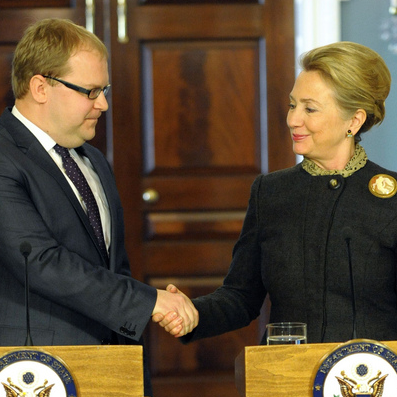

In [7]:
test_dataset[0][0]

<IPython.core.display.Javascript object>


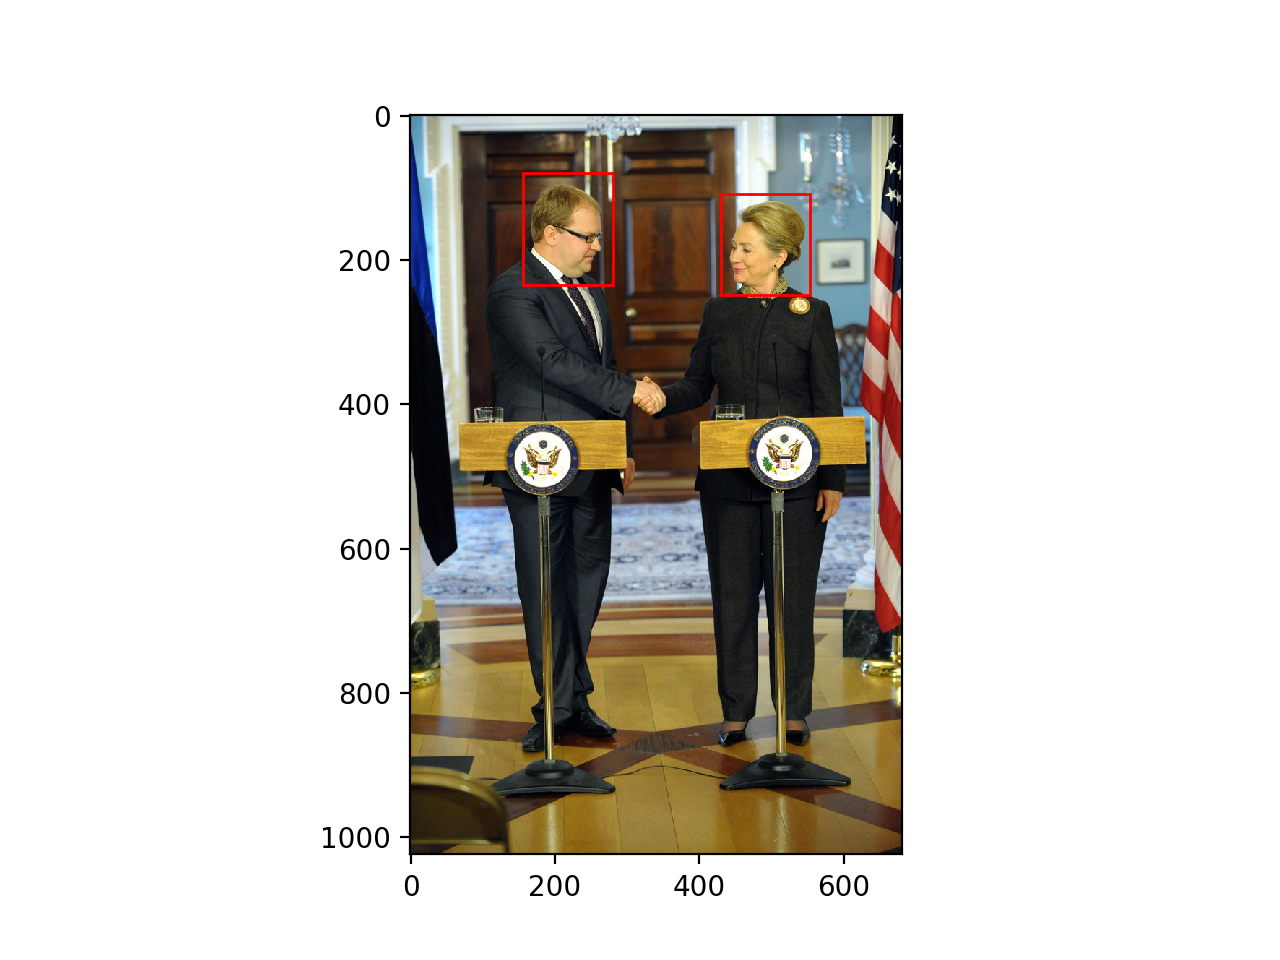

photoset: 72157625740089589, photo id: 5389863377, identity: 1, subs: 1, 2


In [273]:
get_photo_by_photo_id(5389863377)

In [212]:
for i, label in enumerate(dataset.labels):
    if label == 0:
        print(i)
        break

0


In [229]:
model = resnet18(pretrained=False)
model.fc = nn.Linear(512 , 5)

saved = torch.load('saved_models/model_image_pipa_Mar.06_16.20.29/model_last.pt.tar')

model.load_state_dict(saved['state_dict'])
model.eval()
model = model.to('cpu')
saved['epoch']

34

In [47]:
model = resnet18(pretrained=False)
model.fc = nn.Linear(512 , 5)

saved = torch.load('saved_models/model_image_pipa_Apr.08_14.02.52/model_last.pt.tar')

model.load_state_dict(saved['state_dict'])
model.eval()
model = model.to('cpu')
saved['epoch']

20

In [266]:
res = model(batch)[0].max(dim=1).indices
res_back = model(back_batch)[0].max(dim=1).indices

In [236]:
labels

tensor([1, 1, 2, 3, 3, 0, 0, 0, 1, 0, 1, 2, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 1, 2,
        0, 3, 0, 0, 2, 0, 0, 0, 0, 0, 1, 1, 2, 0, 0, 1, 0, 0, 1, 1, 3, 1, 1, 0,
        0, 0, 2, 4, 2, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 3, 0, 0, 0, 0, 2, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 0])

In [268]:
res

tensor([1, 3, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 1, 1, 4, 1, 0, 0, 0, 1,
        1, 2, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        3, 1, 0, 0, 4, 4, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 2, 2, 0, 1, 1,
        0, 1, 1, 0])

In [267]:
res_back

tensor([1, 0, 1, 1, 4, 2, 0, 0, 0, 4, 0, 0, 0, 0, 2, 4, 4, 0, 4, 2, 2, 4, 4, 0,
        0, 2, 0, 0, 2, 1, 2, 2, 2, 2, 0, 4, 3, 1, 4, 1, 1, 0, 0, 0, 1, 0, 0, 3,
        1, 0, 2, 2, 4, 4, 2, 1, 4, 0, 0, 3, 1, 1, 0, 0, 3, 3, 4, 3, 0, 3, 4, 2,
        0, 1, 2, 0, 0, 0, 4, 0, 0, 0, 1, 1, 1, 4, 2, 2, 0, 0, 1, 1, 0, 4, 1, 1,
        0, 1, 1, 2])

In [233]:
labels_back

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])

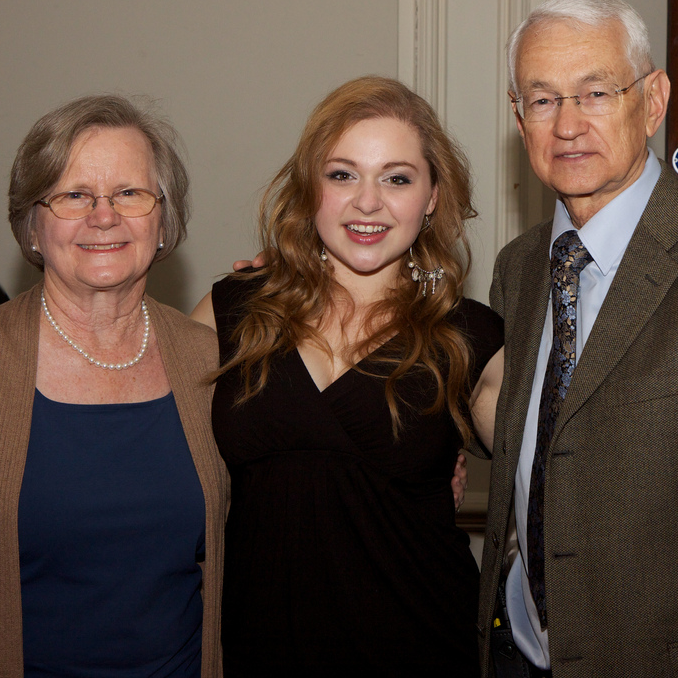

In [260]:
test_dataset[102][0]

In [234]:
(res_back == labels_back).sum()

tensor(46)

In [235]:
(res == labels).sum()

tensor(90)

In [81]:
res.shape

torch.Size([100])

In [ ]:
http://gpu/saved_models/model_image_pipa_Mar.06_11.51.23/log.txt

In [35]:
test_dataset.target_identities

[1, 10, 44, 96]

In [37]:
counts = defaultdict(int)
for _, qq in test_dataset.data_list:
    for qqp in qq:
        if qqp in test_dataset.target_identities:
            counts[qqp]+=1
print(counts)

defaultdict(<class 'int'>, {1: 9, 10: 10, 44: 15, 96: 9})


In [38]:
len(test_dataset)

2444

In [ ]:
# no poison /model_image_pipa_Apr.08_12.36.38. 
